In [1]:
import sys
sys.path.insert(0, './src/yelp_prediction')

In [2]:
import polars as pl
import dataframes as df
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
(df_businesses, df_exact_stars, df_photos_per_business, df_photos) = pl.collect_all(
    (
        df.q_businesses,
        df.q_exact_stars,
        df.q_photos_agg,
        df.q_photos
    )
)

In [4]:
predictions = pl.read_csv("data/predictions.csv")
display(predictions)

epoch,photo_id,prediction
i64,str,f64
1,"""lX-iezxQbtsaS0rgDKuYfw""",2.203205
1,"""hyAM4uUaGx7kn9o4JJKydQ""",2.247413
1,"""OpzKbWLslrikl1SwrPxUNw""",2.666441
1,"""Qng7MtAudpyg84y75N0Wdw""",3.728245
1,"""wVMzxjowkVpvEtbZVu4x5g""",3.82823
…,…,…
20,"""pR89dqENMusZnatz2mS0sA""",3.885188
20,"""RMyP2O5aa_nL3ABjv11q8Q""",3.520645
20,"""nlYG1lzyaVrlEOjT4t3LSw""",4.023876


In [5]:
table = (
    df_photos.join(predictions, on="photo_id")
    .join(df_exact_stars, on="business_id")
    .join(df_businesses, on="business_id")
    .join(df_photos_per_business, on="business_id")
    .select(
        pl.col("epoch"),
        pl.col("photo_id"),
        pl.col("business_id"),
        pl.col("photo_count").alias("business_photo_count"),
        pl.col("label"),
        pl.col("review_count").alias("business_review_count"),
        pl.col("prediction"),
        pl.col("exact_stars").alias("actual"),
    )
    .with_columns(
        (pl.col("prediction") - pl.col("actual")).alias("error"),
    )
    .with_columns(
        pl.col("error").abs().alias("abs_error"),
    )
)

display(table)

epoch,photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
i64,str,str,u32,str,i64,f64,f64,f64,f64
1,"""lX-iezxQbtsaS0rgDKuYfw""","""Y87bVaGb0WU9PIHN1S-AWA""",3,"""food""",82,2.203205,1.465909,0.737296,0.737296
1,"""hyAM4uUaGx7kn9o4JJKydQ""","""Y87bVaGb0WU9PIHN1S-AWA""",3,"""food""",82,2.247413,1.465909,0.781504,0.781504
1,"""OpzKbWLslrikl1SwrPxUNw""","""Y87bVaGb0WU9PIHN1S-AWA""",3,"""food""",82,2.666441,1.465909,1.200532,1.200532
1,"""Qng7MtAudpyg84y75N0Wdw""","""tf5JMBd-HUackUePWPlawQ""",4,"""inside""",459,3.728245,3.70913,0.019115,0.019115
1,"""wVMzxjowkVpvEtbZVu4x5g""","""tf5JMBd-HUackUePWPlawQ""",4,"""food""",459,3.82823,3.70913,0.1191,0.1191
…,…,…,…,…,…,…,…,…,…
20,"""pR89dqENMusZnatz2mS0sA""","""zURelxN8KhAmi3uxuQtC_g""",6,"""food""",62,3.885188,3.919355,-0.034167,0.034167
20,"""RMyP2O5aa_nL3ABjv11q8Q""","""zURelxN8KhAmi3uxuQtC_g""",6,"""food""",62,3.520645,3.919355,-0.39871,0.39871
20,"""nlYG1lzyaVrlEOjT4t3LSw""","""zURelxN8KhAmi3uxuQtC_g""",6,"""food""",62,4.023876,3.919355,0.104521,0.104521


In [6]:
table_by_epoch = (
    table.group_by("epoch")
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .with_columns(
        pl.col("mse").sqrt().alias("rmse"),
    )
    .sort("epoch")
)

display(table_by_epoch)


epoch,mae,mse,rmse
i64,f64,f64,f64
1,0.396261,0.264549,0.514343
2,0.388405,0.255512,0.505481
3,0.382607,0.25361,0.503597
4,0.384845,0.254038,0.504022
5,0.379056,0.251849,0.501846
…,…,…,…
16,0.383264,0.257117,0.507067
17,0.385346,0.253442,0.50343
18,0.384174,0.252885,0.502877


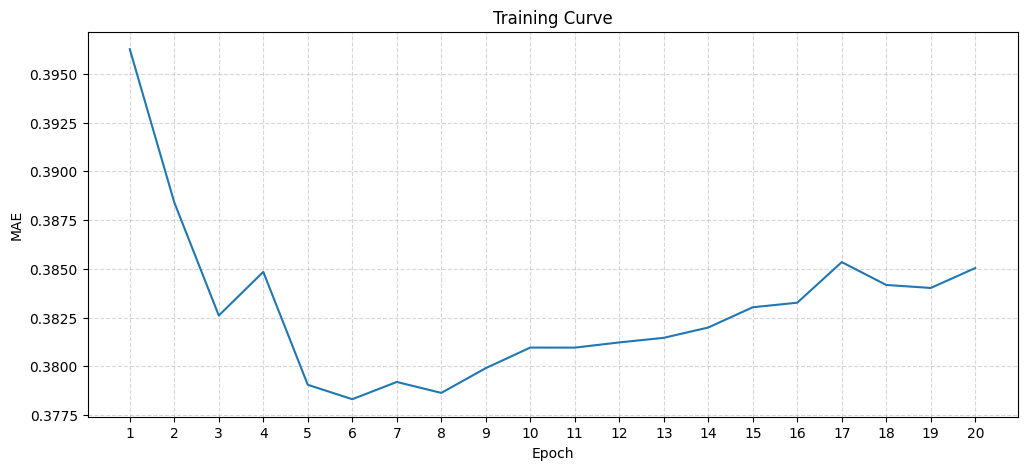

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(
    table_by_epoch["epoch"],
    table_by_epoch["mae"],
)
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.xticks(range(1, 21))
plt.grid(True, which="both", ls="--", alpha=0.5)

In [8]:
def _get_best_table_by(col: str):
    best_epoch = table_by_epoch.sort(by=col).slice(0, 1).select("epoch").item()
    best_epoch_table = table.filter(pl.col("epoch") == best_epoch).drop("epoch")
    return best_epoch, best_epoch_table


best_epoch, best_epoch_table = _get_best_table_by("mae")
display(best_epoch_table)

photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
str,str,u32,str,i64,f64,f64,f64,f64
"""lX-iezxQbtsaS0rgDKuYfw""","""Y87bVaGb0WU9PIHN1S-AWA""",3,"""food""",82,1.989208,1.465909,0.523299,0.523299
"""hyAM4uUaGx7kn9o4JJKydQ""","""Y87bVaGb0WU9PIHN1S-AWA""",3,"""food""",82,2.15466,1.465909,0.688751,0.688751
"""OpzKbWLslrikl1SwrPxUNw""","""Y87bVaGb0WU9PIHN1S-AWA""",3,"""food""",82,2.106703,1.465909,0.640794,0.640794
"""Qng7MtAudpyg84y75N0Wdw""","""tf5JMBd-HUackUePWPlawQ""",4,"""inside""",459,3.681965,3.70913,-0.027164,0.027164
"""wVMzxjowkVpvEtbZVu4x5g""","""tf5JMBd-HUackUePWPlawQ""",4,"""food""",459,3.764916,3.70913,0.055787,0.055787
…,…,…,…,…,…,…,…,…
"""pR89dqENMusZnatz2mS0sA""","""zURelxN8KhAmi3uxuQtC_g""",6,"""food""",62,3.870643,3.919355,-0.048712,0.048712
"""RMyP2O5aa_nL3ABjv11q8Q""","""zURelxN8KhAmi3uxuQtC_g""",6,"""food""",62,3.618186,3.919355,-0.301169,0.301169
"""nlYG1lzyaVrlEOjT4t3LSw""","""zURelxN8KhAmi3uxuQtC_g""",6,"""food""",62,4.008522,3.919355,0.089167,0.089167


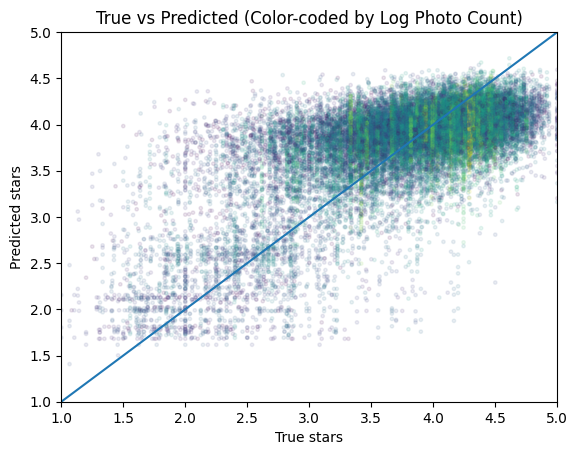

In [9]:
plt.figure()
plt.scatter(
    x=best_epoch_table["actual"],
    y=best_epoch_table["prediction"],
    c=best_epoch_table["business_photo_count"],
    norm=colors.LogNorm(
        vmin=best_epoch_table["business_photo_count"].min(), # type: ignore
        vmax=best_epoch_table["business_photo_count"].max(), # type: ignore
    ),
    cmap='viridis',
    s=6,
    alpha=0.1,
)
plt.plot([1, 5], [1, 5])
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.xlabel("True stars")
plt.ylabel("Predicted stars")
plt.title("True vs Predicted (Color-coded by Log Photo Count)")

None

In [10]:
aggr_by_business = best_epoch_table.group_by("business_id").agg(
    pl.col("abs_error").mean(),
    pl.col("business_photo_count").first(),
    pl.col("business_review_count").first(),
)

aggr_by_business

business_id,abs_error,business_photo_count,business_review_count
str,f64,u32,i64
"""yAxmPYbC6a0jAwdm_WzDhA""",0.325336,6,98
"""D4Uw7MZVGd4QLZF_dxk-Pw""",0.415505,22,681
"""0kCTBibanJj054Fu4dIF2g""",0.152173,9,94
"""aPNXGTDkf-4bjhyMBQxqpQ""",0.613534,4,65
"""AvzL0RmCg5YrLKlBit664A""",0.154139,16,172
…,…,…,…
"""ePs4Z_Nqsm5-kQk_hAp2Dg""",1.1957,1,167
"""EYan1paMumyAUZDhvVyzbg""",0.145608,10,153
"""GdqZaRx-gN8IxrmqYTXcbA""",0.460583,4,65


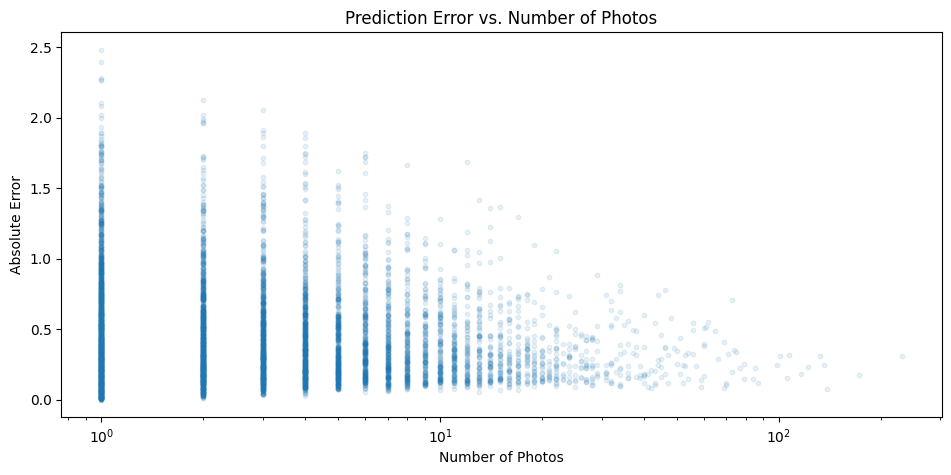

In [11]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_photo_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Photos")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")

None

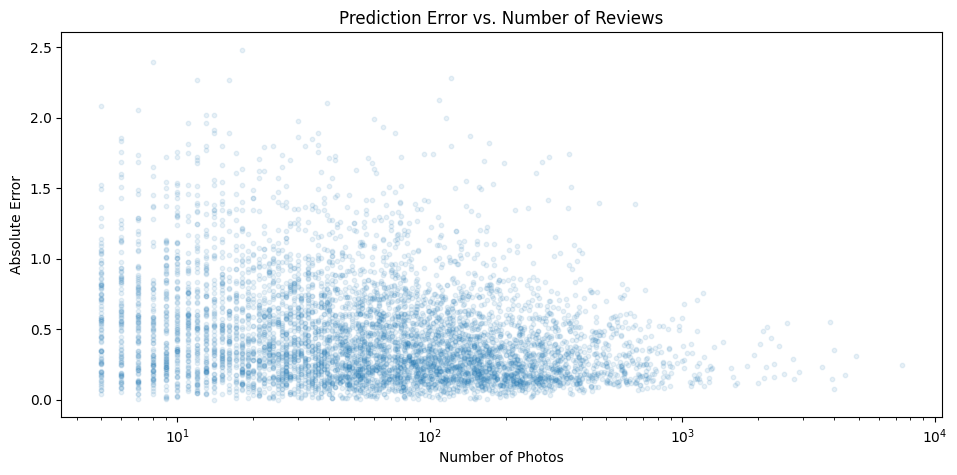

In [12]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_review_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Reviews")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")
None